In [529]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import backend as K

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import joblib


**Define input data and plot them**

In [530]:
# Define lookback and prediction time_step
lookback = 10
time_step = 1 
test_size = 10
future_size = 28
n_features = 2

n_epochs=3000

In [531]:
#number od days
n = 59

final_sequence = []
increment = 10

final_sequence=[increment+2*i for i in range(n)]
final_sequence[0:5]

#convert into df
data_origin=pd.DataFrame(final_sequence, columns=['value'])
data_origin.head(16)

,value
0,10
1,12
2,14
3,16
4,18
5,20
6,22
7,24
8,26
9,28


In [532]:
def zero_value(data):
    data.loc[data['weekend'] == 1, 'value'] = 0
    return data

In [533]:
data_origin['date']=pd.date_range('2022-01-01', periods=len(data_origin))
data_origin['weekend']=data_origin['date'].dt.weekday
data_origin['weekend']=data_origin['weekend'].apply(lambda x: 0 if x not in [0,6] else 1)

#zero the weekends values
data = zero_value(data_origin)

#set the index
data.set_index('date', inplace=True)
data.head(8)

,value,weekend
date,,
2022-01-01,10,0
2022-01-02,0,1
2022-01-03,0,1
2022-01-04,16,0
2022-01-05,18,0
2022-01-06,20,0
2022-01-07,22,0
2022-01-08,24,0


In [534]:
""" #add column holidays
data['holidays']=0

#choose some days as holidays 
list_hol=[10,52,93]

for item in list_hol:
    data.loc[item, 'holidays']=1
    data.loc[item, 'value']=0 """

" #add column holidays\ndata['holidays']=0\n\n#choose some days as holidays \nlist_hol=[10,52,93]\n\nfor item in list_hol:\n    data.loc[item, 'holidays']=1\n    data.loc[item, 'value']=0 "

In [535]:
data_origin.tail(8)

,value,weekend
date,,
2022-02-21,0,1
2022-02-22,114,0
2022-02-23,116,0
2022-02-24,118,0
2022-02-25,120,0
2022-02-26,122,0
2022-02-27,0,1
2022-02-28,0,1


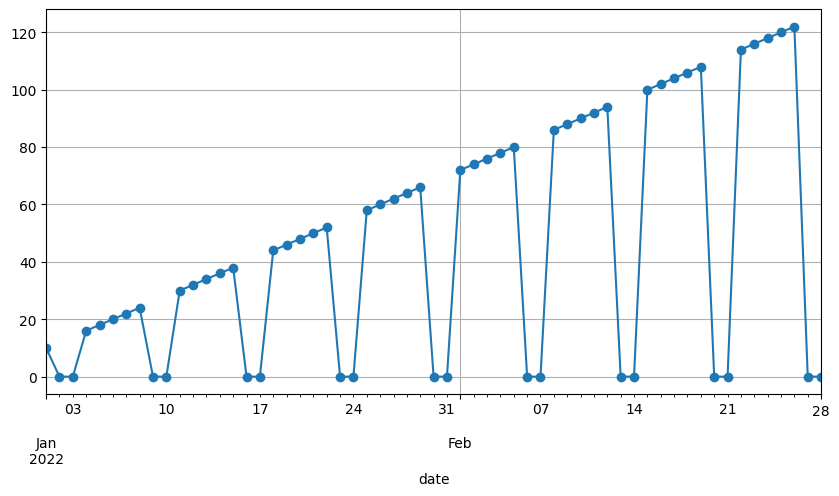

In [536]:
data_origin['value'].plot(figsize=(10,5), marker='o')
plt.grid()
plt.show()

**Scale and parce the data**

In [537]:
#scale data
scaler = MinMaxScaler(feature_range= (0,1))
data = scaler.fit_transform(data)

In [538]:
# Function to create input sequences and corresponding output for training
def create_sequences(data, lookback, time_step):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+time_step, 0]) #I want to predict just first feature that is why 0
    return np.array(X), np.array(y)

# Create input sequences and corresponding output
X, y = create_sequences(data, lookback, time_step)

In [539]:
#Split the data into training and testing sets
train_size = int(len(X)-test_size)

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [540]:
y_train.shape

(39, 1)

**Build the NN and compute**

In [541]:
#Build the LSTM model

'''
If you encounter this problem:
"The error AttributeError: module 'keras.backend' has no attribute 'floatx'"
Restart VSC!!!
'''

#clear previous TensorFlow session
K.clear_session()

model = Sequential()
model.add(LSTM(40, input_shape=(lookback, n_features)))
model.add(Dense(time_step))
model.compile(optimizer='adam', loss='mse')

#Train the model
history=model.fit(X_train, y_train, epochs=n_epochs, batch_size=10, validation_data=(X_test, y_test), verbose=0)

#Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")


1/1 [==============================] - 0s 369ms/step - loss: 1.3212e-04
Test Loss: 0.00013212175690568984


In [542]:
#define ploting function for loss function

def plot_training(history_dict, y_axis=[0, 1000]):

    plt.plot(history_dict.history['loss'], label='Loss-Training',  c="blue")
    plt.plot(history_dict.history['val_loss'], label='Loss-Test', c="red")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.ylim(y_axis) #limit of the Y-axis

    plt.legend()
    plt.grid(True)

    plt.show()

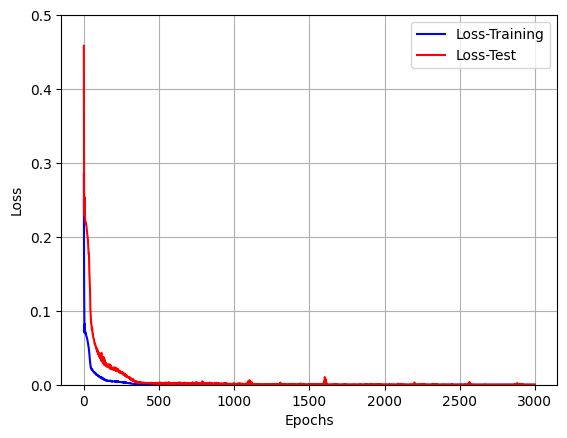

In [543]:
#plot without dropout
plot_training(history,y_axis=[0, 0.5])

**Predict on the test data**

In [544]:
#Predict the next time steps
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 353ms/step


In [545]:
y_pred

array([[8.7388188e-01],
       [4.0977467e-03],
       [3.1812303e-04],
       [9.2691606e-01],
       [9.4315541e-01],
       [9.6058333e-01],
       [9.7842932e-01],
       [9.6940815e-01],
       [4.1440297e-03],
       [6.0206149e-03]], dtype=float32)

In [546]:
#check shape
y_pred.shape

(10, 1)

In [547]:
#copy the array i need to reshape it to the shape (10,2)
y_pred_multi = np.repeat(y_pred, n_features, axis=-1)
y_pred_multi

array([[8.7388188e-01, 8.7388188e-01],
       [4.0977467e-03, 4.0977467e-03],
       [3.1812303e-04, 3.1812303e-04],
       [9.2691606e-01, 9.2691606e-01],
       [9.4315541e-01, 9.4315541e-01],
       [9.6058333e-01, 9.6058333e-01],
       [9.7842932e-01, 9.7842932e-01],
       [9.6940815e-01, 9.6940815e-01],
       [4.1440297e-03, 4.1440297e-03],
       [6.0206149e-03, 6.0206149e-03]], dtype=float32)

In [548]:
#check shape
y_pred_multi.shape

(10, 2)

In [549]:
#tranform back and choose just first column of the array
y_pred_trans=scaler.inverse_transform(y_pred_multi)[:,0]

#reshapefrom row to column
y_pred_trans=y_pred_trans.reshape(-1,1) 
y_pred_trans

array([[1.0661359e+02],
       [4.9992511e-01],
       [3.8811009e-02],
       [1.1308376e+02],
       [1.1506496e+02],
       [1.1719117e+02],
       [1.1936838e+02],
       [1.1826779e+02],
       [5.0557160e-01],
       [7.3451501e-01]], dtype=float32)

In [550]:
###########
#same procedure with the test
###########

#copy the array i need to reshape it to (10,2)
y_test_multi = np.repeat(y_test, n_features, axis=-1)

#tranform back and choose just first column of the array=0
y_test_trans=scaler.inverse_transform(y_test_multi)[:,0]

#reshape from row to column
y_test_trans=y_test_trans.reshape(-1,1) 
y_test_trans


array([[108.],
       [  0.],
       [  0.],
       [114.],
       [116.],
       [118.],
       [120.],
       [122.],
       [  0.],
       [  0.]])

**Plot results**

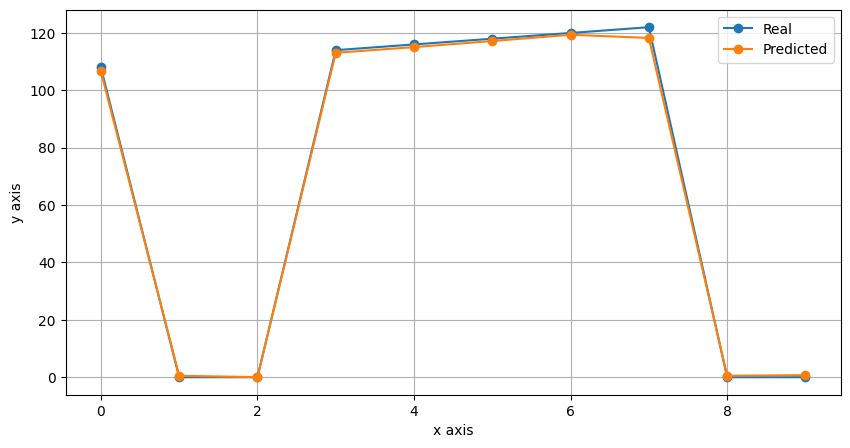

In [551]:
#Plot results for test part

plt.figure(figsize=(10,5))

plt.plot(y_test_trans, label = 'Real', marker='o')
plt.plot(y_pred_trans, label = 'Predicted', marker='o')

plt.grid()
plt.ylabel('y axis')
plt.xlabel('x axis')

plt.legend()
plt.show()

**Evaluate test data - RMSE**

In [552]:
#calculate root mean squared error
test_score = np.sqrt(mse(y_test_trans, y_pred_trans))

#print results
print(f'RMSE: {round(test_score,2)}')


RMSE: 1.4


**Predict beyond the test set**

**Create a matrix**

In [553]:
#get the last date item
first_date=data_origin.index[-1]+pd.Timedelta(days=1)
first_date

Timestamp('2022-03-01 00:00:00')

In [554]:
#get the future prediction
df_future=pd.DataFrame({'date': pd.date_range(first_date,periods=future_size)})

#add nan we will predict them
df_future['value']=np.nan

#add weekend column
df_future['weekend']=df_future['date'].dt.weekday
df_future['weekend']=df_future['weekend'].apply(lambda x: 0 if x not in [0,6] else 1)
df_future=df_future.set_index('date')

df_future

,value,weekend
date,,
2022-03-01,NaN,0
2022-03-02,NaN,0
2022-03-03,NaN,0
2022-03-04,NaN,0
2022-03-05,NaN,0
2022-03-06,NaN,1
2022-03-07,NaN,1
2022-03-08,NaN,0
2022-03-09,NaN,0


In [555]:
#take data from the test set
#add nan we will predict them
df_test=data_origin[-test_size:].copy()
df_test

,value,weekend
date,,
2022-02-19,108,0
2022-02-20,0,1
2022-02-21,0,1
2022-02-22,114,0
2022-02-23,116,0
2022-02-24,118,0
2022-02-25,120,0
2022-02-26,122,0
2022-02-27,0,1


In [556]:
#merge the df
df_prediction_final=pd.concat([df_test, df_future], axis=0)
df_prediction_final

,value,weekend
date,,
2022-02-19,108.0,0
2022-02-20,0.0,1
2022-02-21,0.0,1
2022-02-22,114.0,0
2022-02-23,116.0,0
2022-02-24,118.0,0
2022-02-25,120.0,0
2022-02-26,122.0,0
2022-02-27,0.0,1


In [557]:
#scale data and transform them into an array
scaler = MinMaxScaler(feature_range = (0,1))
df_prediction_final_scaled = scaler.fit_transform(df_prediction_final)

In [558]:
#Fit the model on the whole dataset (including test set)
history=model.fit(X,y, epochs=n_epochs, batch_size=10, verbose=0)
final_loss = history.history['loss'][-1]
final_loss

5.033858997194329e-06

In [ ]:
#Save the fitted model
joblib.dump(model, 'lstm-model-multivariate.pkl')

In [559]:
#array BEFORE the prediction
df_prediction_final_scaled 

array([[0.8852459 , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.93442623, 0.        ],
       [0.95081967, 0.        ],
       [0.96721311, 0.        ],
       [0.98360656, 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 1.        ],
       [       nan, 1.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 1.        ],
       [       nan, 1.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 1.        ],
       [  

In [560]:
#define the function for the prediction
def predict_multivariate(array, lookback):
    results=[]
    for i in range(len(array)-lookback):
        
        batch=[]
        batch.append(array[i:i+lookback , 0:array.shape[1]])
        batch=np.array(batch)
      
        #predict one value
        prediction=model.predict(batch, verbose=0)[0]
        #add to the prediction list
        results.append(prediction[0]) #takes just first values, otherwise there would be a list with 2D arrays

        #replace nan in the array for next iterration
        array[i+lookback,0]=prediction[0] 
    return results

In [561]:
#call the function and predict
results=predict_multivariate(df_prediction_final_scaled, lookback)
results

[1.0388561,
 1.055912,
 1.0697908,
 1.0875837,
 1.1031004,
 0.014089901,
 0.002683241,
 1.128569,
 1.1491014,
 1.160514,
 1.1808563,
 1.1931975,
 0.024491195,
 0.0064745545,
 1.2027782,
 1.2262273,
 1.2341146,
 1.2572355,
 1.2661495,
 0.03720264,
 0.01001757,
 1.2584444,
 1.2848498,
 1.2894801,
 1.3151038,
 1.3205838,
 0.05021597,
 0.013280671]

In [562]:
#array AFTER the prediction
df_prediction_final_scaled

array([[0.8852459 , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.93442623, 0.        ],
       [0.95081967, 0.        ],
       [0.96721311, 0.        ],
       [0.98360656, 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.03885615, 0.        ],
       [1.05591202, 0.        ],
       [1.06979084, 0.        ],
       [1.08758366, 0.        ],
       [1.10310042, 0.        ],
       [0.0140899 , 1.        ],
       [0.00268324, 1.        ],
       [1.12856901, 0.        ],
       [1.14910138, 0.        ],
       [1.160514  , 0.        ],
       [1.18085635, 0.        ],
       [1.19319749, 0.        ],
       [0.02449119, 1.        ],
       [0.00647455, 1.        ],
       [1.20277822, 0.        ],
       [1.22622728, 0.        ],
       [1.23411465, 0.        ],
       [1.25723553, 0.        ],
       [1.26614952, 0.        ],
       [0.03720264, 1.        ],
       [0.

In [563]:
#convert the array into a list
results=np.array(results)
results=results.reshape(-1,1)
results[0:5]

array([[1.0388561],
       [1.055912 ],
       [1.0697908],
       [1.0875837],
       [1.1031004]], dtype=float32)

In [564]:
###########
#transform back
###########

#copy the array i need to reshape it to (10,2)
results_multi = np.repeat(results, n_features, axis=-1)

#tranform back and choose just first column of the array=0
results_trans=scaler.inverse_transform(results_multi)[:,0]
results_trans

array([126.74045   , 128.82126   , 130.51448   , 132.68521   ,
       134.57825   ,   1.7189679 ,   0.32735538, 137.68542   ,
       140.19037   , 141.5827    , 144.06447   , 145.5701    ,
         2.9879258 ,   0.78989565, 146.73894   , 149.59973   ,
       150.56198   , 153.38274   , 154.47025   ,   4.538722  ,
         1.2221435 , 153.53023   , 156.75168   , 157.31657   ,
       160.44266   , 161.11122   ,   6.1263485 ,   1.6202419 ],
      dtype=float32)

In [565]:
results_trans.shape

(28,)

**Plot the results**

In [566]:
#create dataframe
results_df=pd.DataFrame({'predicted': results_trans,
                         'date': pd.date_range(first_date,periods=future_size) })

results_df=results_df.set_index('date')

results_df.head(5)

,predicted
date,
2022-03-01,126.740448
2022-03-02,128.821259
2022-03-03,130.514481
2022-03-04,132.685211
2022-03-05,134.578247


In [567]:
df_prediction=pd.concat([data_origin['value'], results_df], axis=1)
df_prediction.rename(columns={'value': 'true'}, inplace=True)
df_prediction.tail(16)

,true,predicted
date,,
2022-03-13,NaN,2.987926
2022-03-14,NaN,0.789896
2022-03-15,NaN,146.738937
2022-03-16,NaN,149.599731
2022-03-17,NaN,150.561981
2022-03-18,NaN,153.382736
2022-03-19,NaN,154.470245
2022-03-20,NaN,4.538722
2022-03-21,NaN,1.222144


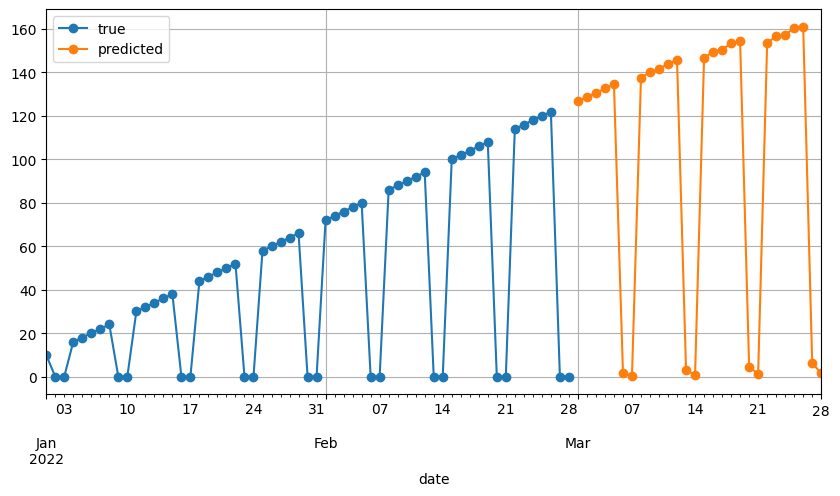

In [568]:
#Plot a chart
df_prediction[['true', 'predicted']].plot(figsize=(10, 5), marker='o')
plt.grid(True)
plt.show()